### Gravitational Orbits in Cartesian Coordinates
This notebook will be solving the problem of two-body gravitational attraction in cartesian coordinates. To do this I will be doing it in multiple steps and parts. 

1. Create a class that solves the differential equation for this two body system. 
2. Show that the problem reduces to the orbits considered in class if one of the bodies is very heavy and you 
   are in its rest frame. 
3. Try and use leapfrog algorithm and show that it uses less energy than the SciPy ODE solver
4. Extend the simulation to 3 bodies in the same plane and comment on the orbits 
5. Create widget to animate orbits 

### Part 1: Solve 2 Body System in Cartesian coordinates


In [5]:
%matplotlib inline 

import numpy as np #for numpy functions
from scipy.integrate import solve_ivp #to be able to solve ivp problems
import matplotlib.pyplot as plt #for plotting
from IPython.display import Image

In [82]:
class gravorbits(): 
    """
    Class uses parameters and Lagrangians for two particles orbiting under gravitational attraction
    
    Parameters: 
    
    m1 = mass 1
    m2 = mass 2 
    G = gravitation 
    """
    
    def __init__(self, m1 =1., m2 = 1. , G = 1.):
        self.m1 = m1
        self.m2 = m2 
        self.G = G 
    
    def dz_dt(self, t, z):
        """
        function returns the rhs of the differential equation using give t and z, where t is time and 
        z is an 8 component vector
        z[0] = x1(t) z[1] = x1_dot(t)
        z[2] = y1(t) z[3] = y1_dot(t)
        z[4] = x2(t) z[5] = x2_dot(t)
        z[6] = y2(t) z[7] = y2_dot(t)
        """
        r_12 = np.sqrt( (z[0] - z[4])**2 + (z[2] - z[6])**2)
        
        return [z[1], self.G * self.m2 * (z[4] - z[0]) / r_12**3, \
               z[3], self.G * self.m2 * (z[6] - z[2]) / r_12**3, \
               z[5], -self.G * self.m1 * (z[4] - z[0]) / r_12**3, \
               z[7], -self.G * self.m1 * (z[6] - z[2]) / r_12**3, \
               ]
    
    def solve_ode(self, t_pts, z0, abserr=1.0e-8, relerr=1.0e-8):
        """
        solves ode given the initial conditions
        """
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]),
                            z0, t_eval=t_pts, method='RK23',
                            atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y
        
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    def solve_ode_LF(self, t_pts, z0):
        """
        solves ode given inital conditions using leapfrog method
        """
        delta_t = t_pts[1] - t_pts[0]
        
        x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0 = z0
        
        #setting arrays with zeros
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        #IC's 
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        
        #stepping through the diffeq
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            z = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            out = self.dz_dt(t,z)
            
            x1_dot_half[i] = x1_dot[i] + out[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + out[1] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + out[1] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + out[1] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            z = [x1[i+1], x1_dot[i], y1[i+1], y1_dot[i], x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            out = self.dz_dt(t,z)
            
            x1_dot[i+1] = x1_dot[i] + out[1] * delta_t/2.
            y1_dot[i+1] = y1_dot[i] + out[3] * delta_t/2.
            x2_dot[i+1] = x2_dot[i] + out[5] * delta_t/2.
            y2_dot[i+1] = y2_dot[i] + out[7] * delta_t/2.
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def energy(self,t_pts, u_pts):
        """
        solves for energy as a function of time
        """
        
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = u_pts
        
        E_tot = 0.5 * self.m1 * (x1_dot**2 + y1_dot**2) + 0.5 * self.m2 * (x2_dot**2 + y2_dot**2) \
                - self.G * self.m1 * self.m2 / np.sqrt((x1 - x2)**2 + (y1-y2)**2)
        return E_tot

In [83]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [84]:
#defining function for start and stop indicies (given in previous problem sets)
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()
    return start_index, stop_index

In [119]:
#making orbit plots

#label for individual axes
orbitlabels = (r'$x$', r'$y$')

#plotting time
t_start = 0.
t_end = 20.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

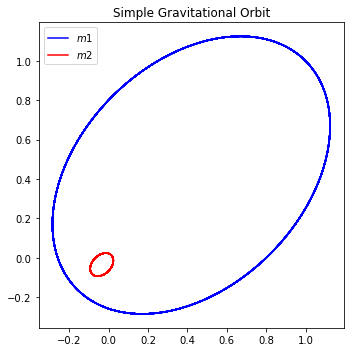

In [120]:
#Initial Values
G = 1. 
m1 = 1 
m2 = 12.

orbit = gravorbits(m1,m2, G)

#initial conditions w/ com veloc zero 
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -(m1 / m2) * x1_0, -(m1 / m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1 / m2) * y1_0, -(m1 / m2) * y1_dot_0

z0 = [x1_0, x1_dot_0,
      y1_0, y1_dot_0,
      x2_0, x2_dot_0, 
      y2_0, y2_dot_0]

x1a, x1a_dot, y1a, y1a_dot, x2a, x2a_dot, y2a, y2a_dot = orbit.solve_ode(t_pts, z0)

#plotting! 
fig = plt.figure(figsize=(5,5))

#for first plot 
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1a, y1a, color='blue', label='$m1$')
ax.plot(x2a, y2a, color='red', label='$m2$')
ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simpleorbit.png', bbox_inches='tight')

### Part 2: Show that this reduces to orbits shown in class if one is heavy and you are in its rest frame

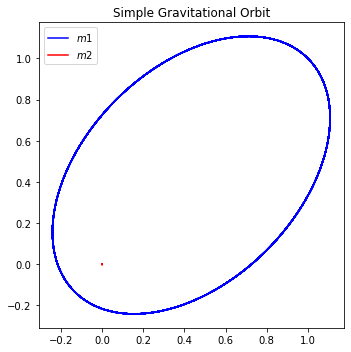

In [121]:
#Initial Values
G = 1. 
m1 = .01 
m2 = 12.

orbit = gravorbits(m1,m2, G)

#initial conditions w/ com veloc zero 
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -(m1 / m2) * x1_0, -(m1 / m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1 / m2) * y1_0, -(m1 / m2) * y1_dot_0

z0 = [x1_0, x1_dot_0,
      y1_0, y1_dot_0,
      x2_0, x2_dot_0, 
      y2_0, y2_dot_0]

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = orbit.solve_ode(t_pts, z0)

#plotting! 
fig = plt.figure(figsize=(5,5))

#for first plot 
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1, y1, color='blue', label='$m1$')
ax.plot(x2, y2, color='red', label='$m2$')
ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simpleorbit1.png', bbox_inches='tight')

### Part 3: Use leapfrog algorithm and show that it uses less energy

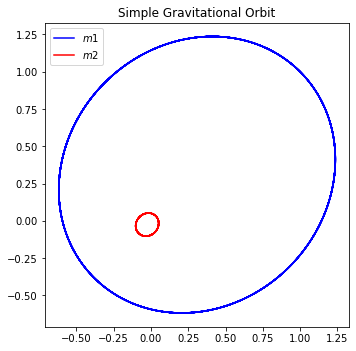

In [122]:
#Initial Values
G = 1. 
m1 = 1. 
m2 = 12.

orbit = gravorbits(m1,m2, G)

#initial conditions w/ com veloc zero 
x1_0, x1_dot_0 = 1., -1.
y1_0, y1_dot_0 = 1., 1.
x2_0, x2_dot_0 = -(m1 / m2) * x1_0, -(m1 / m2) * x1_dot_0
y2_0, y2_dot_0 = -(m1 / m2) * y1_0, -(m1 / m2) * y1_dot_0

z0 = [x1_0, x1_dot_0,
      y1_0, y1_dot_0,
      x2_0, x2_dot_0, 
      y2_0, y2_dot_0]

x1_LF, x1_dot_LF, y1_LF, y1_dot_LF, x2_LF, x2_dot_LF, y2_LF, y2_dot_LF = orbit.solve_ode_LF(t_pts, z0)

#plotting! 
fig = plt.figure(figsize=(5,5))

#for first plot 
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x1_LF, y1_LF, color='blue', label='$m1$')
ax.plot(x2_LF, y2_LF, color='red', label='$m2$')
ax.set_title('Simple Gravitational Orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()
fig.savefig('simpleorbit1.png', bbox_inches='tight')

In [123]:
u_pts = x1a, x1a_dot, y1a, y1a_dot, x2a, x2a_dot, y2a, y2a_dot
u_pts_LF = x1_LF, x1_dot_LF, y1_LF, y1_dot_LF, x2_LF, x2_dot_LF, y2_LF, y2_dot_LF

#For RK23
E_tot_pts = orbit.energy(t_pts, u_pts )
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

#for LF
E_tot_pts_LF = orbit.energy(t_pts, u_pts_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

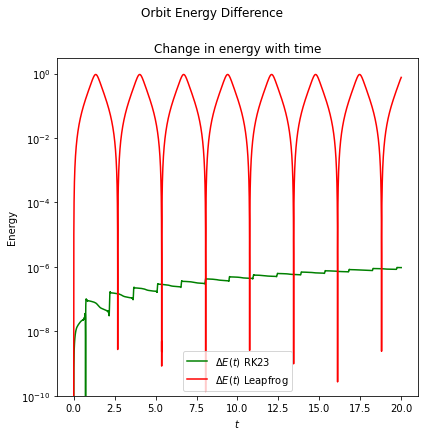

In [124]:
fig_5 = plt.figure(figsize=(6,6))

overall_title = 'Orbit Energy Difference'  # \n means a new line (adds some space here)
fig_5.suptitle(overall_title, va='baseline')

ax_5a = fig_5.add_subplot(1,1,1)
#ax_5a.semilogy(t_pts, np.abs(E_tot_pts), color='black', label=r'$E(t)$')
ax_5a.semilogy(t_pts, E_tot_rel_pts, 
               color='green', label=r'$\Delta E(t)$ RK23')
ax_5a.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')
ax_5a.set_ylim(1.e-10, 3.)    # (1.e-12, 5)
ax_5a.set_xlabel(r'$t$')
ax_5a.set_ylabel(r'Energy')
ax_5a.set_title('Change in energy with time')
ax_5a.legend()

fig_5.tight_layout()
fig_5.savefig('Leapfrog_energy_1.png', dpi=200, bbox_inches='tight')

### Part 4: Extend to 3 bodies in same plane

### Part 5: Create Widget to animate